In [ ]:
!git clone https://github.com/Jackie-2000/team4project.git

fatal: destination path 'team4project' already exists and is not an empty directory.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset, Dataset
import os
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
from nltk.tokenize import word_tokenize
import gensim
from gensim import models
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
word2vec_path = '/content/drive/MyDrive/GoogleNews-vectors-negative300.bin'
w2v_model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:

def load_files(train_path, eval_path, debug=False, n=2):
  """
  Numpy file loading
  args:
  train_path (str) -> train file path
  eval_path (str) -> eval file path
  debug (Bool ) -> (optional) print debug statements
  n (int) -> number of examples to be printed
  """
  # file_loading
  wp_train = np.load(train_path, allow_pickle=True)
  wp_eval = np.load(eval_path, allow_pickle=True)

  if debug:

    print(f"train dtype: {wp_train.dtype}\n")
    print(f"train shape: {wp_train.shape}\n")
    print(f"train first {n} samples: {wp_train[:n]}\n")
    print(f"eval dtype: {wp_eval.dtype}\n")
    print(f"eval shape: {wp_eval.shape}\n")
    print(f"eval first {n} samples: {wp_eval[:n]}")


  return wp_train, wp_eval


wp_train, wp_eval = load_files('/content/team4project/data/WP-train.npy', '/content/team4project/data/SP_eval_data_for_practice.npy', debug=True)
sp_train, sp_eval = load_files('/content/team4project/data/SP-train.npy', '/content/team4project/data/SP_eval_data_for_practice.npy', debug=True)

train dtype: object

train shape: (396,)

train first 2 samples: [{'id': 'WP-0', 'question': 'How do you spell COW in thirteen letters?', 'answer': 'SEE O DOUBLE YOU.', 'distractor1': 'COWCOWCOWCOWW', 'distractor2': 'SEE OH DEREFORD', 'distractor(unsure)': 'None of above.', 'label': 1, 'choice_list': ['SEE OH DEREFORD', 'SEE O DOUBLE YOU.', 'COWCOWCOWCOWW', 'None of above.'], 'choice_order': [2, 0, 1, 3]}
 {'id': 'WP-0_SR', 'question': 'In thirteen letters, how do you spell COW?', 'answer': 'SEE O DOUBLE YOU.', 'distractor1': 'COWCOWCOWCOWW', 'distractor2': 'SEE OH DEREFORD', 'distractor(unsure)': 'None of above.', 'label': 2, 'choice_list': ['SEE OH DEREFORD', 'COWCOWCOWCOWW', 'SEE O DOUBLE YOU.', 'None of above.'], 'choice_order': [2, 1, 0, 3]}]

eval dtype: object

eval shape: (120,)

eval first 2 samples: [{'question': 'Everyone called him "Batman," but he knew nothing about bats and thought they were disgusting. He still cherished being referred to as Batman! How is this possible?

In [ ]:
sp_train[0]

{'id': 'SP-0',
 'question': 'Mr. and Mrs. Mustard have six daughters and each daughter has one brother. But there are only 9 people in the family, how is that possible?',
 'answer': 'Each daughter shares the same brother.',
 'distractor1': 'Some daughters get married and have their own family.',
 'distractor2': 'Some brothers were not loved by family and moved away.',
 'distractor(unsure)': 'None of above.',
 'label': 1,
 'choice_list': ['Some daughters get married and have their own family.',
  'Each daughter shares the same brother.',
  'Some brothers were not loved by family and moved away.',
  'None of above.'],
 'choice_order': [1, 0, 2, 3]}

In [ ]:
wp_train[0]

{'id': 'WP-0',
 'question': 'How do you spell COW in thirteen letters?',
 'answer': 'SEE O DOUBLE YOU.',
 'distractor1': 'COWCOWCOWCOWW',
 'distractor2': 'SEE OH DEREFORD',
 'distractor(unsure)': 'None of above.',
 'label': 1,
 'choice_list': ['SEE OH DEREFORD',
  'SEE O DOUBLE YOU.',
  'COWCOWCOWCOWW',
  'None of above.'],
 'choice_order': [2, 0, 1, 3]}

In [ ]:
pad_seq = "<pad>"

In [ ]:
def df_converter(data):
  """
     Data formatting for the dataset and conversion to df
  """

  df = pd.DataFrame()
  q, a1, a2, a3, a4, c = [],[],[],[],[],[]

  for dp in tqdm(data):
    c.append(dp['choice_order'].index(0))
    a1.append(dp['choice_list'][dp['choice_order'][0]])
    a2.append(dp['choice_list'][dp['choice_order'][1]])
    a3.append(dp['choice_list'][dp['choice_order'][2]])
    a4.append(dp['choice_list'][dp['choice_order'][3]])
    q.append(dp['question'])
  df['question'], df['answer1'], df['answer2'], df['answer3'], df['answer4'], df['choice'] = q, a1, a2, a3, a4, c

  return df

In [ ]:
df = df_converter(wp_train)
df = df.append(df_converter(sp_train))
#eval_df = df_converter(wp_eval)

100%|██████████| 507/507 [00:00<00:00, 172006.16it/s]
<ipython-input-10-7733f8643045>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_converter(sp_train))


In [ ]:
df.shape

(903, 6)

In [ ]:
df.head()

,question,answer1,answer2,answer3,answer4,choice
0,How do you spell COW in thirteen letters?,COWCOWCOWCOWW,SEE OH DEREFORD,SEE O DOUBLE YOU.,None of above.,1
1,"In thirteen letters, how do you spell COW?",SEE O DOUBLE YOU.,COWCOWCOWCOWW,SEE OH DEREFORD,None of above.,2
2,How do you spell COB in seven letters?,COBBLER,SEE O BEE,COBCOBB,None of above.,2
3,"If eleven plus two equals one, what does nine ...",Three.,Four.,Two.,None of above.,1
4,What does nine plus five equal if eleven plus ...,Two.,Three.,Four.,None of above.,1


In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2)

In [ ]:
train_df.head()

,question,answer1,answer2,answer3,answer4,choice
177,"Always in visible, yet never out of sight.\nWh...",The letters I and S.,The letters V and S.,The letters V and I.,None of above.,0
29,"In three letters, how do you spell ""laughter""?",L A T.,L T R.,F U N.,None of above.,1
321,What's a computer's favorite snack?,Chips.,Cookie.,Candy.,None of above.,1
72,Four men were in a boat on the lake. The boat ...,"Despite the boat turning over and sinking, the...","The lake was frozen, none of the men got wet d...",Because they were all married and not single.,None of above.,1
362,The kind of mouse engineers like most？,A white mouse.,A computer mouse.,A young mouse.,None of above.,2


In [ ]:
train_df.shape

(722, 6)

In [ ]:
train_df['question'] = train_df['question'].apply(lambda x: "<START> " +x + " <END>")
valid_df['question'] = valid_df['question'].apply(lambda x: "<START> " +x + " <END>")

In [ ]:
train_df.head()


,question,answer1,answer2,answer3,answer4,choice
177,"<START> Always in visible, yet never out of si...",The letters I and S.,The letters V and S.,The letters V and I.,None of above.,0
29,"<START> In three letters, how do you spell ""la...",L A T.,L T R.,F U N.,None of above.,1
321,<START> What's a computer's favorite snack? <END>,Chips.,Cookie.,Candy.,None of above.,1
72,<START> Four men were in a boat on the lake. T...,"Despite the boat turning over and sinking, the...","The lake was frozen, none of the men got wet d...",Because they were all married and not single.,None of above.,1
362,<START> The kind of mouse engineers like most？...,A white mouse.,A computer mouse.,A young mouse.,None of above.,2


In [ ]:
train_df.choice.value_counts()

1    235
2    228
0    214
3     45
Name: choice, dtype: int64

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
"this is a test sentence".split()

['this', 'is', 'a', 'test', 'sentence']

In [ ]:
class VocabEmbedding(object):
    def __init__(self, w2v_model):
      self.w2v = w2v_model
      self.w2v.add_vector('<START>', np.random.uniform(low=-1, high=1.0, size=(300,)))
      self.w2v.add_vector('<END>', np.random.uniform(low=-1, high=1.0, size=(300,)))
      self.w2v.add_vector('<pad>', np.random.uniform(low=-1, high=1.0, size=(300,)))
      self.w2v.add_vector('<unk>', np.random.uniform(low=-1, high=1.0, size=(300,)))

      bos = self.w2v.key_to_index.get('<START>')
      eos = self.w2v.key_to_index.get('<END>')
      pad = self.w2v.key_to_index.get('<pad>')
      unk = self.w2v.key_to_index.get('<unk>')

      self.bos_index = bos
      self.eos_index = eos
      self.pad_index = pad
      self.unk_index = unk


    def tokenizer(self, text):

        return [i for i in text.split(' ')]




    def encode(self, text, questions=True):

        sequence = []
        if questions:
          tokens = self.tokenizer(text)
        else:
          tokens = [c for word in text.split(' ') for c in word]  # converting to characters

        for token in tokens:
            index = self.w2v.key_to_index.get(token, self.unk_index)
            sequence.append(index)

        return sequence


    def create_padded_tensor(self, sequences, max_length=256):
        tensor = torch.full((len(sequences), max_length), self.pad_index, dtype=torch.long)



        for i, sequence in enumerate(sequences):
            for j, token in enumerate(sequence):

                tensor[i][j] = token

        return tensor

In [ ]:
class TaggerDataset(Dataset):
    def __init__(self, data, text_sequencer):

        self.data = data

        self.input_sequencer = text_sequencer


    def __getitem__(self, index):
        q, a1, a2, a3, a4, c = self.data[index]

        question = self.input_sequencer.encode(q)
        answer1 = self.input_sequencer.encode(a1, questions=False)
        answer2 = self.input_sequencer.encode(a2, questions=False)
        answer3 = self.input_sequencer.encode(a3, questions=False)
        answer4 = self.input_sequencer.encode(a4, questions=False)


        return torch.tensor(question).to(device),torch.tensor(answer1).to(device), \
              torch.tensor(answer2).to(device), torch.tensor(answer3).to(device), \
                torch.tensor(answer4).to(device), torch.tensor(c).to(device)


    def __len__(self):
        return len(self.data)

In [ ]:
train_data = [(row['question'], row['answer1'],
               row['answer2'], row['answer3'],
               row['answer4'], row['choice']
               ) for i,row in train_df.iterrows()]

val_data = [(row['question'], row['answer1'],
               row['answer2'], row['answer3'],
               row['answer4'], row['choice']) for i, row in valid_df.iterrows()]

In [ ]:
text_sequencer = VocabEmbedding(w2v_model)

/usr/local/lib/python3.10/dist-packages/gensim/models/keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


In [ ]:
train_dataset = TaggerDataset(train_data, text_sequencer)
val_dataset = TaggerDataset(val_data, text_sequencer)

In [ ]:
next(iter(train_dataset))

(tensor([3000000,   12378,       1, 3000003,     506,     292,      49, 3000003,
         3000003,      19, 3000003, 3000001], device='cuda:0'),
 tensor([   2367,   23199,    4211,   15775,    4211,    7726,    7726,    4211,
           17919,    1280,      20, 3000003,    5760,    8469,    3581, 3000003],
        device='cuda:0'),
 tensor([   2367,   23199,    4211,   15775,    4211,    7726,    7726,    4211,
           17919,    1280,    5915, 3000003,    5760,    8469,    3581, 3000003],
        device='cuda:0'),
 tensor([   2367,   23199,    4211,   15775,    4211,    7726,    7726,    4211,
           17919,    1280,    5915, 3000003,    5760,    8469,      20, 3000003],
        device='cuda:0'),
 tensor([   5773,   11538,    5760,    4211,   11538,   17251, 3000003,    7332,
           11538,    6878,    4211, 3000003], device='cuda:0'),
 tensor(0, device='cuda:0'))

In [ ]:
batch_size=16

In [ ]:
def prepare_batch(batch, input_sequencer, max_length_answers):
    questions, a1, a2, a3, a4, labels = zip(*batch)
    q = input_sequencer.create_padded_tensor(questions)
    a1 = input_sequencer.create_padded_tensor(a1, max_length=max_length_answers)
    a2 = input_sequencer.create_padded_tensor(a2, max_length=max_length_answers)
    a3 = input_sequencer.create_padded_tensor(a3, max_length=max_length_answers)
    a4 = input_sequencer.create_padded_tensor(a4, max_length=max_length_answers)

    a1 = torch.cat((q,a1) , dim=1)
    a2 = torch.cat((q,a2) , dim=1)
    a3 = torch.cat((q,a3) , dim=1)
    a4 = torch.cat((q,a4) , dim=1)


    return (a1.to(device), a2.to(device), a3.to(device), a4.to(device), torch.Tensor(labels).to(device))

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=lambda batch: prepare_batch(batch, text_sequencer, 256))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, collate_fn=lambda batch: prepare_batch(batch, text_sequencer, 256), shuffle=False)

In [ ]:
class CNNAttentionModel(nn.Module):
    def __init__(self, embedding_dim, hidden_size, num_classes, w2v_model, kernel_size=3, stride=1, freeze_embedding=True):
        super(CNNAttentionModel, self).__init__()
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(w2v_model.vectors), padding_idx=1, freeze=freeze_embedding)

        self.hidden_size = hidden_size

        self.conv1 = nn.Conv2d(1, 28, kernel_size=kernel_size, stride=stride, padding=2)
        self.conv2 = nn.Conv2d(28, 64, kernel_size=kernel_size, stride=stride, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=kernel_size, stride=stride, padding=2)

        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1_att = nn.Linear(10752, 10752)

        # Fully connected layers for classification
        self.fc1 = nn.Linear(10752, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)
        self.softmax = nn.Softmax(dim=1)


    def cnn_forward(self, embeddings):
        pass1 = self.max_pool(nn.functional.relu(self.conv1(embeddings)))
        pass2 = self.max_pool(nn.functional.relu(self.conv2(pass1)))
        pass3 = self.max_pool(nn.functional.relu(self.conv3(pass2)))
        flatten = torch.flatten(pass3, start_dim=1)
        return flatten


    def forward(self, a1, a2, a3, a4, debug=False):
        a1_embed = self.embedding(a1)
        a2_embed = self.embedding(a2)
        a3_embed = self.embedding(a3)
        a4_embed = self.embedding(a4)

        #Running CNN through the question
        if debug:
          print('q embedding size', a1_embed.size())
          print('q embedding with added dimension size', a1_embed.unsqueeze(1).size())


        a1_flat = self.cnn_forward(a1_embed.unsqueeze(1))
        a2_flat = self.cnn_forward(a2_embed.unsqueeze(1))
        a3_flat = self.cnn_forward(a3_embed.unsqueeze(1))
        a4_flat = self.cnn_forward(a4_embed.unsqueeze(1))

        combined_tensor = torch.cat((a1_flat, a2_flat, a3_flat, a4_flat), dim=1)

        if debug:
          print('combined tensor size', combined_tensor.size())



        att_weights = torch.softmax(self.fc1_att(combined_tensor), dim=1)
        att_output = torch.mul(combined_tensor, att_weights)


        if debug:
          print('attention weights shape', att_weights.size())
          print('attention outputs', att_output)



        out = nn.functional.relu(self.fc1(att_output))
        out = self.dropout(out)
        out = self.fc2(out)

        return out

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
import gc
try:
  del model
  gc.collect()
  torch.cuda.empty_cache()
except:
  gc.collect()
  torch.cuda.empty_cache()

In [ ]:
512*4

2048

In [ ]:

model = CNNAttentionModel(300, 15, 4, w2v_model,kernel_size=7, stride=2, freeze_embedding=True).to(device)
#model = LSTM_Model(output_size, tag_sequencer.pad_index, rnn_hidden_size=hidden_size, num_layers=30, w2v_weights=torch.FloatTensor(w2v_model.vectors)).to(device)

print('trainable parameters',count_parameters(model))



for i, batch in tqdm(enumerate(train_loader)):

    logits = model(batch[0], batch[1], batch[2], batch[3], debug=True)
    break


trainable parameters 116795516


0it [00:00, ?it/s]

q embedding size torch.Size([16, 512, 300])
q embedding with added dimension size torch.Size([16, 1, 512, 300])
combined tensor size torch.Size([16, 10752])
attention weights shape torch.Size([16, 10752])
attention outputs tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.4926e-06, 3.5269e-06,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.5117e-06, 3.5383e-06,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.5009e-06, 3.5269e-06,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.5094e-06, 3.5269e-06,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.5018e-06, 3.5357e-06,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.5201e-06, 3.5278e-06,
         0.0000e+00]], device='cuda:0', grad_fn=<MulBackward0>)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 30

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for a1, a2, a3, a4, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(a1, a2, a3, a4)
        loss = criterion(outputs, labels.type(torch.LongTensor).to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)


    # Calculate accuracy on test set after each epoch
    model.eval()
    correct = 0
    total = 0
    val_running_loss = 0.0
    with torch.no_grad():
        for a1, a2, a3, a4, labels in val_loader:
            outputs = model(a1, a2, a3, a4)
            loss = criterion(outputs, labels.type(torch.LongTensor).to(device))
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            # print('********************************************')
            # print('\n\nValidations', labels)
            # print('\n\nPredictions',predicted)
            # print('\n********************************************\n')

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_losses.append(val_loss)

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {epoch_loss:.4f} Test Accuracy: {accuracy:.2f}%")

torch.save(model.state_dict(), '/content/drive/MyDrive/CNN_trained_model.pth')

Epoch [1/30] Loss: 1.3303 Test Accuracy: 32.04%
Epoch [2/30] Loss: 1.2900 Test Accuracy: 32.04%
Epoch [3/30] Loss: 1.2738 Test Accuracy: 32.04%
Epoch [4/30] Loss: 1.2547 Test Accuracy: 31.49%
Epoch [5/30] Loss: 1.2089 Test Accuracy: 32.04%
Epoch [6/30] Loss: 1.1671 Test Accuracy: 32.04%
Epoch [7/30] Loss: 1.1597 Test Accuracy: 31.49%
Epoch [8/30] Loss: 1.1404 Test Accuracy: 35.91%
Epoch [9/30] Loss: 1.1188 Test Accuracy: 35.36%
Epoch [10/30] Loss: 1.1196 Test Accuracy: 35.91%
Epoch [11/30] Loss: 1.1035 Test Accuracy: 35.91%
Epoch [12/30] Loss: 1.0918 Test Accuracy: 36.46%
Epoch [13/30] Loss: 1.0830 Test Accuracy: 36.46%
Epoch [14/30] Loss: 1.0890 Test Accuracy: 35.91%
Epoch [15/30] Loss: 1.0749 Test Accuracy: 36.46%
Epoch [16/30] Loss: 1.0774 Test Accuracy: 36.46%
Epoch [17/30] Loss: 1.0654 Test Accuracy: 36.46%
Epoch [18/30] Loss: 1.0672 Test Accuracy: 35.91%
Epoch [19/30] Loss: 1.0626 Test Accuracy: 36.46%
Epoch [20/30] Loss: 1.0566 Test Accuracy: 36.46%
Epoch [21/30] Loss: 1.0681 Te

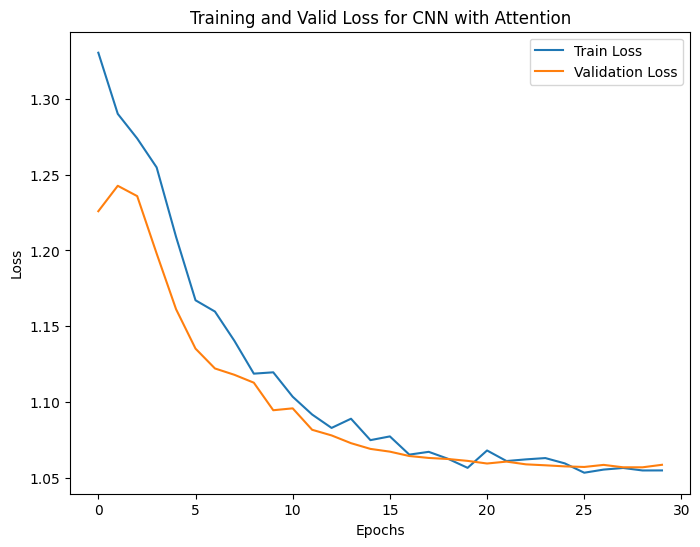

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Valid Loss for CNN with Attention')
plt.legend()
plt.show()